In [188]:
import numpy as np 
import pandas as pd
import warnings
import os 
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import holidays
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from datetime import date


warnings.filterwarnings("ignore")

In [189]:
df_train = pd.read_csv('/kaggle/input/redbus-challenge/train.csv')
df_trans = pd.read_csv('/kaggle/input/redbus-challenge/transactions.csv')

In [190]:
df_train.head()

,doj,srcid,destid,final_seatcount
0,2023-03-01,45,46,2838.0
1,2023-03-01,46,45,2298.0
2,2023-03-01,45,47,2720.0
3,2023-03-01,47,45,2580.0
4,2023-03-01,46,9,4185.0


In [191]:
df_trans.head()

,doj,doi,srcid,destid,srcid_region,destid_region,srcid_tier,destid_tier,cumsum_seatcount,cumsum_searchcount,dbd
0,2023-03-01,2023-01-30,45,46,Karnataka,Tamil Nadu,Tier 1,Tier 1,8.0,76.0,30
1,2023-03-01,2023-01-30,46,45,Tamil Nadu,Karnataka,Tier 1,Tier 1,8.0,70.0,30
2,2023-03-01,2023-01-30,45,47,Karnataka,Andhra Pradesh,Tier 1,Tier 1,4.0,142.0,30
3,2023-03-01,2023-01-30,47,45,Andhra Pradesh,Karnataka,Tier 1,Tier 1,0.0,68.0,30
4,2023-03-01,2023-01-30,46,9,Tamil Nadu,Tamil Nadu,Tier 1,Tier2,9.0,162.0,30


### Analysis of data

In [192]:
df_trans.groupby('srcid_region')['srcid'].unique()

srcid_region
Andhra Pradesh                            [47, 5, 28, 43, 3, 8, 6]
Delhi                                                         [36]
East 1                                         [13, 23, 25, 17, 4]
Karnataka                                                 [45, 42]
Kerala                                                        [34]
Madhya Pradesh                                            [19, 32]
Maharashtra and Goa                 [2, 40, 30, 16, 31, 14, 21, 1]
Rajasthan                                                     [12]
Rest of North                          [11, 7, 27, 41, 37, 22, 38]
Tamil Nadu             [46, 9, 48, 35, 44, 18, 26, 15, 20, 39, 33]
Name: srcid, dtype: object

In [193]:
df_trans.groupby('destid_region')['destid'].unique()

destid_region
Andhra Pradesh                        [47, 5, 28, 43, 3, 6, 8, 10]
Delhi                                                         [36]
East 1                                            [23, 25, 13, 29]
Karnataka                                                 [45, 42]
Kerala                                                        [34]
Madhya Pradesh                                            [32, 19]
Maharashtra and Goa             [40, 30, 2, 16, 31, 14, 21, 1, 24]
Rajasthan                                                     [12]
Rest of North                              [11, 7, 27, 37, 41, 22]
Tamil Nadu             [46, 9, 48, 44, 35, 18, 15, 26, 20, 39, 33]
Name: destid, dtype: object

In [194]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67200 entries, 0 to 67199
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   doj              67200 non-null  object 
 1   srcid            67200 non-null  int64  
 2   destid           67200 non-null  int64  
 3   final_seatcount  67200 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 2.1+ MB


In [195]:
df_train['doj'] = pd.to_datetime(df_train['doj'])
df_train.corr()['final_seatcount']

doj                0.160178
srcid              0.125972
destid             0.129146
final_seatcount    1.000000
Name: final_seatcount, dtype: float64

In [196]:
df_train.describe()

,doj,srcid,destid,final_seatcount
count,67200,67200.000000,67200.000000,67200.000000
mean,2024-01-30 12:00:00,29.550000,29.750000,2001.729464
min,2023-03-01 00:00:00,1.000000,1.000000,2.000000
25%,2023-08-15 18:00:00,14.750000,15.750000,1252.000000
50%,2024-01-30 12:00:00,36.000000,34.500000,1685.000000
75%,2024-07-16 06:00:00,45.000000,45.000000,2408.000000
max,2024-12-31 00:00:00,48.000000,48.000000,13503.000000
std,NaN,16.670082,15.938986,1194.711140


In [197]:
df_trans['doj'] = pd.to_datetime(df_trans['doj'])
df_trans['doi'] = pd.to_datetime(df_trans['doi'])
df_trans['doj'] = df_trans['doj'].dt.date
df_trans['doi'] = df_trans['doi'].dt.date

df_trans.describe()

,srcid,destid,cumsum_seatcount,cumsum_searchcount,dbd
count,2.266100e+06,2.266100e+06,2.266100e+06,2.266100e+06,2.266100e+06
mean,2.955000e+01,2.975000e+01,1.738379e+02,4.742158e+03,1.500000e+01
std,1.666996e+01,1.593887e+01,4.858925e+02,1.673550e+04,8.944274e+00
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.475000e+01,1.575000e+01,0.000000e+00,2.080000e+02,7.000000e+00
50%,3.600000e+01,3.450000e+01,1.600000e+01,7.640000e+02,1.500000e+01
75%,4.500000e+01,4.500000e+01,1.000000e+02,2.896000e+03,2.300000e+01
max,4.800000e+01,4.800000e+01,1.350300e+04,1.677297e+06,3.000000e+01


#### Note: **100 different routes over a span of about 21 months**

In [198]:
# Split transaction based on train and test doj and take only dates 15 days before doj

train = df_trans[df_trans['doj'] <= date(2024, 12, 31)]


In [199]:
train.describe()

,srcid,destid,cumsum_seatcount,cumsum_searchcount,dbd
count,2.083200e+06,2.083200e+06,2.083200e+06,2.083200e+06,2.083200e+06
mean,2.955000e+01,2.975000e+01,1.875000e+02,5.085192e+03,1.500000e+01
std,1.666996e+01,1.593887e+01,5.039996e+02,1.736684e+04,8.944274e+00
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.475000e+01,1.575000e+01,0.000000e+00,2.490000e+02,7.000000e+00
50%,3.600000e+01,3.450000e+01,2.000000e+01,8.640000e+02,1.500000e+01
75%,4.500000e+01,4.500000e+01,1.160000e+02,3.225000e+03,2.300000e+01
max,4.800000e+01,4.800000e+01,1.350300e+04,1.677297e+06,3.000000e+01


In [200]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2083200 entries, 0 to 2083199
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   doj                 object 
 1   doi                 object 
 2   srcid               int64  
 3   destid              int64  
 4   srcid_region        object 
 5   destid_region       object 
 6   srcid_tier          object 
 7   destid_tier         object 
 8   cumsum_seatcount    float64
 9   cumsum_searchcount  float64
 10  dbd                 int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 190.7+ MB


In [201]:
## Extracting the date, month and year for further analysis

train['year'] = train['doj'].apply(lambda x: x.year)
train['month'] = train['doj'].apply(lambda x: x.month)
train['day'] = train['doj'].apply(lambda x: x.day)
train['day_of_week'] = train['doj'].apply(lambda x: x.strftime('%A'))  # e.g., 'Monday'
train.head()

,doj,doi,srcid,destid,srcid_region,destid_region,srcid_tier,destid_tier,cumsum_seatcount,cumsum_searchcount,dbd,year,month,day,day_of_week
0,2023-03-01,2023-01-30,45,46,Karnataka,Tamil Nadu,Tier 1,Tier 1,8.0,76.0,30,2023,3,1,Wednesday
1,2023-03-01,2023-01-30,46,45,Tamil Nadu,Karnataka,Tier 1,Tier 1,8.0,70.0,30,2023,3,1,Wednesday
2,2023-03-01,2023-01-30,45,47,Karnataka,Andhra Pradesh,Tier 1,Tier 1,4.0,142.0,30,2023,3,1,Wednesday
3,2023-03-01,2023-01-30,47,45,Andhra Pradesh,Karnataka,Tier 1,Tier 1,0.0,68.0,30,2023,3,1,Wednesday
4,2023-03-01,2023-01-30,46,9,Tamil Nadu,Tamil Nadu,Tier 1,Tier2,9.0,162.0,30,2023,3,1,Wednesday


In [202]:
train['destid_tier'].unique()

array(['Tier 1', 'Tier2', 'Tier 3', 'Tier 4'], dtype=object)

In [203]:
train['srcid_tier'].unique()

array(['Tier 1', 'Tier2', 'Tier 3', 'Tier 4'], dtype=object)

In [204]:
# Mapping tier to number (ordinal mapping)

train['srcid_tier']=train['srcid_tier'].map({'Tier 1':4,'Tier2':3,'Tier 3':2,'Tier 4':1})
train['destid_tier']=train['destid_tier'].map({'Tier 1':4,'Tier2':3,'Tier 3':2,'Tier 4':1})

In [205]:
# Adding target(final seat count) to the data
train['final_seat_count'] = train.groupby(['srcid','destid','doj'])['cumsum_seatcount'].transform('max')


In [206]:
'''# Step 1: Group and aggregate
route_stats = train.groupby(['srcid', 'destid','dbd'])['cumsum_seatcount'].agg(
    route_min='min',
    route_max='max',
    route_mean='mean',
    route_median='median',
    route_std='std'
).reset_index()

# Step 2: Merge back to the original DataFrame
train = train.merge(route_stats, on=['srcid', 'destid','dbd'], how='left')'''


"# Step 1: Group and aggregate\nroute_stats = train.groupby(['srcid', 'destid','dbd'])['cumsum_seatcount'].agg(\n    route_min='min',\n    route_max='max',\n    route_mean='mean',\n    route_median='median',\n    route_std='std'\n).reset_index()\n\n# Step 2: Merge back to the original DataFrame\ntrain = train.merge(route_stats, on=['srcid', 'destid','dbd'], how='left')"

In [207]:
## Considering rows with dbd>=15

train = train[train.dbd>=15]

# Exploratory Data Analysis

In [208]:
print('# Same state: ',train[train.srcid_region==train.destid_region].shape[0])
print('# Different states: ',train[train.srcid_region!=train.destid_region].shape[0])

# Same state:  612864
# Different states:  462336


In [209]:
numeric_cols = train.select_dtypes(include=['int32','int64', 'float64']).columns

# Calculate correlation with final_seat_count
correlations = train[numeric_cols].corr()[['final_seat_count']] \
                .sort_values('final_seat_count', ascending=False)

# Display results (excluding self-correlation)
print(correlations[correlations.index != 'final_seat_count'])


                    final_seat_count
cumsum_seatcount        3.913359e-01
cumsum_searchcount      3.445068e-01
year                    1.400237e-01
destid                  1.291462e-01
srcid                   1.259721e-01
srcid_tier              1.056655e-01
destid_tier             8.537328e-02
month                   5.512844e-02
day                     1.055118e-02
dbd                    -3.721256e-16


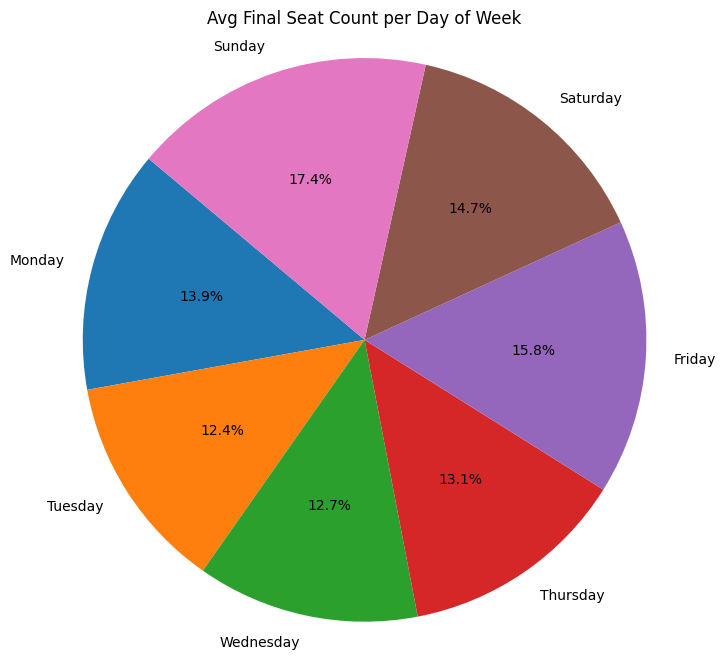

In [212]:

# Group and get max seat counts
max_seat_by_day = train.groupby('day_of_week')['final_seat_count'].mean()

# Sort by day order (optional, for cleaner visuals)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
max_seat_by_day = max_seat_by_day.reindex(day_order)

# Plot as pie chart
plt.figure(figsize=(8, 8))
plt.pie(max_seat_by_day, labels=max_seat_by_day.index, autopct='%1.1f%%', startangle=140)
plt.title('Avg Final Seat Count per Day of Week')
plt.axis('equal')  # Equal aspect ratio ensures the pie is circular
plt.show()


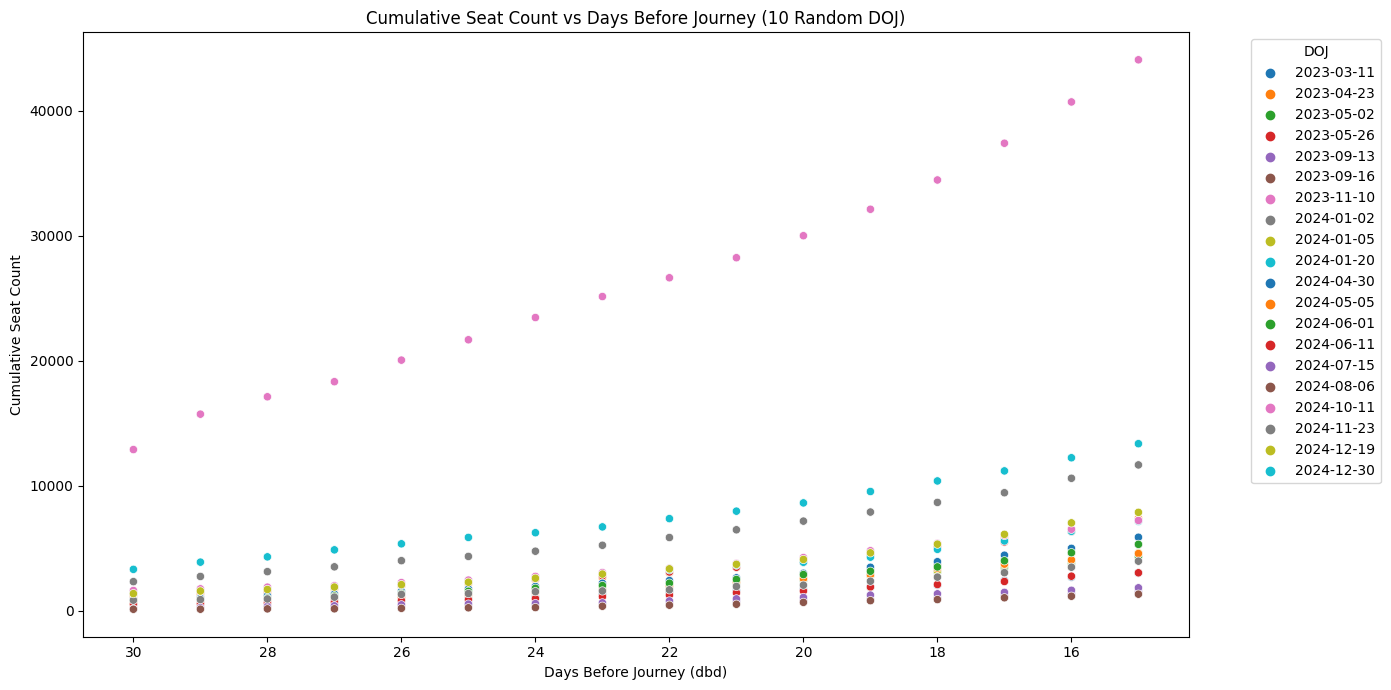

In [213]:
# Sample 10 random unique 'doj' values
sampled_dates = train['doj'].drop_duplicates().sample(20)

# Filter the data to only include those dates
sample_data = train[train['doj'].isin(sampled_dates)]

# Sort for consistent plotting
sample_data = sample_data.sort_values(['doj', 'dbd'], ascending=[True, False])


plot_data = sample_data.groupby(['doj', 'dbd'])['cumsum_seatcount'].sum().reset_index()

# Plot
plt.figure(figsize=(14, 7))
sns.scatterplot(data=plot_data, x='dbd', y='cumsum_seatcount', hue='doj', palette='tab10')

plt.title('Cumulative Seat Count vs Days Before Journey (10 Random DOJ)')
plt.xlabel('Days Before Journey (dbd)')
plt.ylabel('Cumulative Seat Count')
plt.gca().invert_xaxis()  # Show dbd decreasing left to right
plt.legend(title='DOJ', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [214]:
train.groupby('srcid_tier')['final_seat_count'].mean()

srcid_tier
1    1760.951265
2    1641.160218
3    1917.110887
4    2099.182077
Name: final_seat_count, dtype: float64

In [215]:
train.groupby('destid_tier')['final_seat_count'].mean()

destid_tier
1    1976.116071
2    1689.240434
3    1911.671656
4    2096.840694
Name: final_seat_count, dtype: float64

In [216]:
train.groupby(['srcid_tier','destid_tier'])['final_seat_count'].mean()

srcid_tier  destid_tier
1           3              1656.469494
            4              1865.433036
2           4              1641.160218
3           1              2192.392857
            3              1525.977927
            4              2003.424045
4           1              1867.977679
            2              1689.240434
            3              2020.308837
            4              2323.461434
Name: final_seat_count, dtype: float64

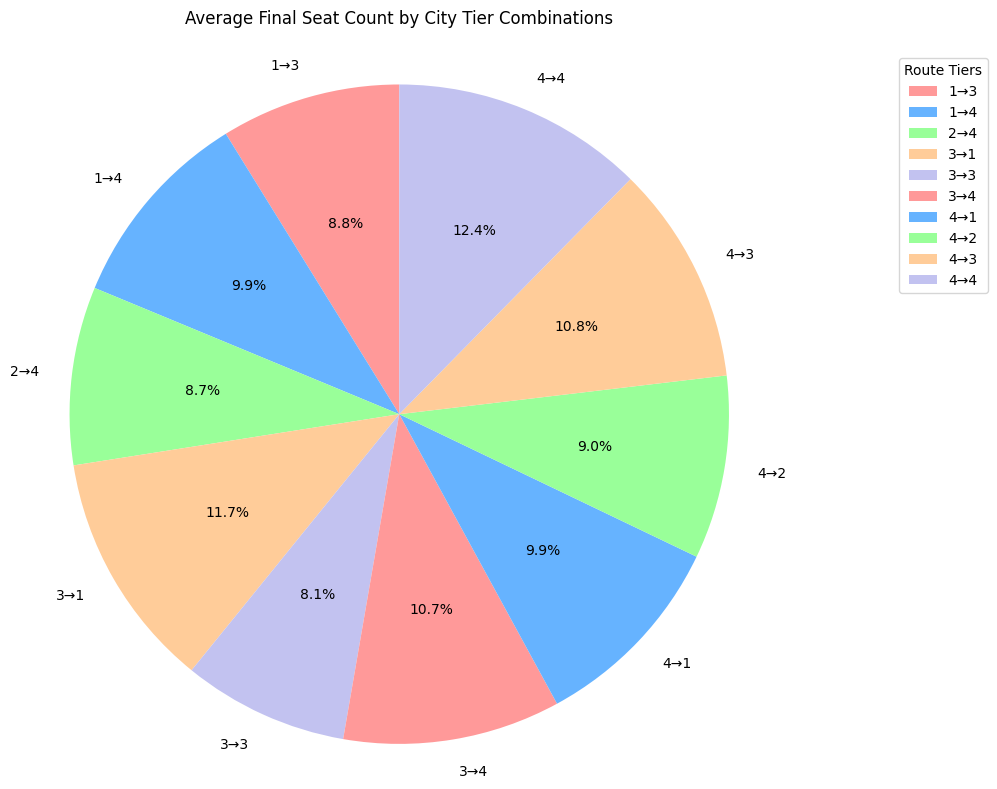

In [217]:

# Calculate mean seat counts by tier combinations
tier_counts = train.groupby(['srcid_tier','destid_tier'])['final_seat_count'].mean()

# Create the pie chart
plt.figure(figsize=(10, 8))
plt.pie(tier_counts, 
        labels=tier_counts.index.map(lambda x: f"{x[0]}→{x[1]}"), 
        autopct='%1.1f%%',
        startangle=90,
        colors=['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0'])

plt.title('Average Final Seat Count by City Tier Combinations', pad=20)
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as circle

# Add legend
plt.legend(title="Route Tiers",
           loc="upper right",
           bbox_to_anchor=(1.3, 1))

plt.tight_layout()
plt.show()


# From tier 1 - 42%
#from tier 2 - 30.5
# from tier 3 - 8.7
#from tier 4 - 18.7


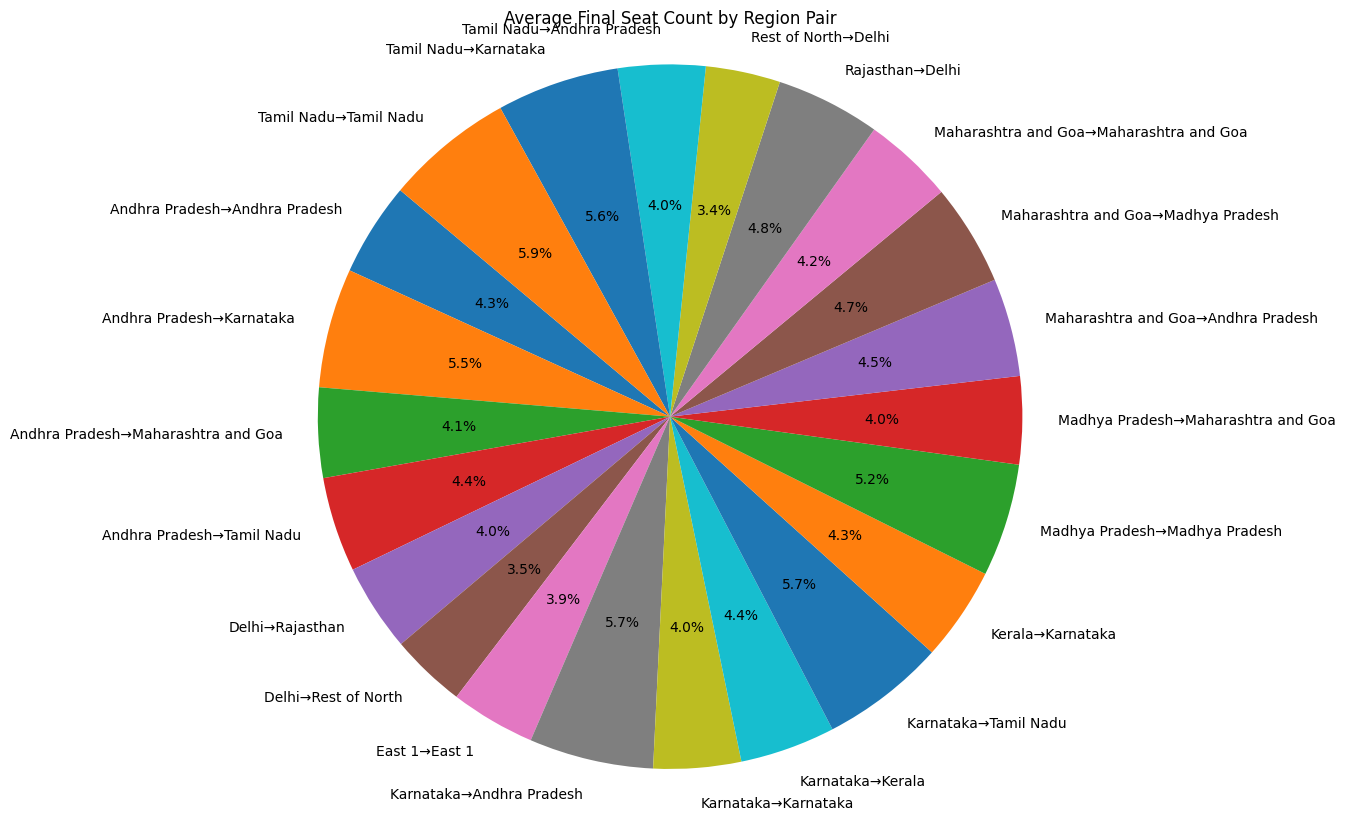

In [218]:
# Group and get mean final seat count
region_pairs = train.groupby(['srcid_region', 'destid_region'])['final_seat_count'].mean()

# Convert index to string labels like "MH → KA"
region_labels = [f"{src}→{dest}" for src, dest in region_pairs.index]
region_values = region_pairs.values

# Plot
plt.figure(figsize=(10, 10))
plt.pie(region_values, labels=region_labels, autopct='%1.1f%%', startangle=140)
plt.title('Average Final Seat Count by Region Pair')
plt.axis('equal')  # Makes the pie circular
plt.show()


In [219]:
print('Avg')
print('Intra state: ',train[train.srcid_region == train.destid_region]['final_seat_count'].mean())
print('Inter state: ',train[train.srcid_region != train.destid_region]['final_seat_count'].mean())
print('Median')
print('Intra state: ',train[train.srcid_region == train.destid_region]['final_seat_count'].median())
print('Inter state: ',train[train.srcid_region != train.destid_region]['final_seat_count'].median())
print('Max')
print('Intra state: ',train[train.srcid_region == train.destid_region]['final_seat_count'].max())
print('Inter state: ',train[train.srcid_region != train.destid_region]['final_seat_count'].max())

Avg
Intra state:  2028.421548663325
Inter state:  1966.3469338316722
Median
Intra state:  1684.0
Inter state:  1695.0
Max
Intra state:  13503.0
Inter state:  13364.0


#### Check for holidays and long weekends

In [220]:
!pip install -q holidays

In [221]:
# Indian holidays for 2025
indian_holidays = holidays.India(years=2024)

# List all holidays
for day, name in sorted(indian_holidays.items()):
    print(day, name)


print('\n')
# Indian holidays for 2025
indian_holidays = holidays.India(years=2023)

# List all holidays
for day, name in sorted(indian_holidays.items()):
    print(day, name)


2024-01-26 Republic Day
2024-03-08 Maha Shivaratri
2024-03-29 Good Friday
2024-04-11 Eid al-Fitr
2024-04-21 Mahavir Jayanti
2024-05-23 Buddha Purnima
2024-06-17 Eid al-Adha
2024-07-17 Ashura
2024-08-15 Independence Day
2024-08-26 Janmashtami
2024-09-16 Prophet's Birthday
2024-10-02 Gandhi Jayanti
2024-10-12 Dussehra
2024-11-01 Diwali
2024-11-15 Guru Nanak Jayanti
2024-12-25 Christmas


2023-01-26 Republic Day
2023-02-18 Maha Shivaratri
2023-04-04 Mahavir Jayanti
2023-04-07 Good Friday
2023-04-22 Eid al-Fitr
2023-05-05 Buddha Purnima
2023-06-29 Eid al-Adha
2023-07-29 Ashura
2023-08-15 Independence Day
2023-09-07 Janmashtami
2023-09-28 Prophet's Birthday
2023-10-02 Gandhi Jayanti
2023-10-24 Dussehra
2023-11-12 Diwali
2023-11-27 Guru Nanak Jayanti
2023-12-25 Christmas


In [222]:
# Define Indian holidays for the relevant year(s)
indian_holidays = holidays.India(years=train['year'].unique())

# Get a set of dates 3 days before and after each holiday
holiday_buffer = set()

for holiday in indian_holidays.keys():
    for offset in range(-4, 5):  # -3 to +3 days
        holiday_buffer.add(holiday + timedelta(days=offset))

#train['near_holiday'] = train['doj'].isin(holiday_buffer)


top_seats = sorted(train['final_seat_count'].unique())[-20:]
print(top_seats)

for i in top_seats:
    print('\n')
    doj=train[train['final_seat_count'] == i]['doj'].iloc[0]
    print(doj)
    print(train[train['final_seat_count'] == i].loc[:, ['doj', 'day_of_week', 'final_seat_count']].head(1),doj in holiday_buffer )
    print( )

[10134.0, 10326.0, 10452.0, 10467.0, 10674.0, 10716.0, 10788.0, 10854.0, 10868.0, 11008.0, 11025.0, 11319.0, 11529.0, 11680.0, 12024.0, 12219.0, 12684.0, 13200.0, 13364.0, 13503.0]


2023-10-02
               doj day_of_week  final_seat_count
666505  2023-10-02      Monday           10134.0 True



2024-10-13
                doj day_of_week  final_seat_count
1835205  2024-10-13      Sunday           10326.0 True



2024-08-14
                doj day_of_week  final_seat_count
1649204  2024-08-14   Wednesday           10452.0 True



2024-10-20
                doj day_of_week  final_seat_count
1856905  2024-10-20      Sunday           10467.0 False



2024-04-21
                doj day_of_week  final_seat_count
1292705  2024-04-21      Sunday           10674.0 True



2023-08-11
               doj day_of_week  final_seat_count
505304  2023-08-11      Friday           10716.0 True



2024-11-03
                doj day_of_week  final_seat_count
1900316  2024-11-03      Sunday           107

#### Note: Max seats filled are 3-4 days around a holiday

In [223]:
top_seats = sorted(train['final_seat_count'].unique())[-1000:]

print('Max: ',top_seats[-1],'Min: ',top_seats[0])
print('\n')
is_highest_hol ={'True':0,'FalsebutWeekend':0,'Nope':0}
for i in top_seats:
    doj=train[train['final_seat_count'] == i]['doj'].iloc[0]
    dow=train[train['final_seat_count'] == i]['day_of_week'].iloc[0]
    if doj in holiday_buffer:
        is_highest_hol['True']+=1
    elif dow in ['Friday','Saturday','Sunday']:
        is_highest_hol['FalsebutWeekend']+=1
    else:
        is_highest_hol['Nope']+=1

        
print(is_highest_hol)  
    

Max:  13503.0 Min:  5258.0


{'True': 520, 'FalsebutWeekend': 346, 'Nope': 134}


#### Note: ~ 23% of the journeys have bookings just few days before doj, which isnt covered in the 30-15 days dbd history data.

In [224]:
dojs_with_all_zeros = train.groupby(['doj','srcid','destid'])['cumsum_seatcount'].apply(lambda x: (x == 0).all())
dojs_with_all_zeros = dojs_with_all_zeros[dojs_with_all_zeros].index.tolist()
unique_pairs_count = train[['doj', 'srcid', 'destid']].drop_duplicates().shape[0]

len(dojs_with_all_zeros),unique_pairs_count

(15756, 67200)

### Checking influence of doi

In [225]:
train['year_doi'] = train['doi'].apply(lambda x: x.year)
train['month_doi'] = train['doi'].apply(lambda x: x.month)
train['day_doi'] = train['doi'].apply(lambda x: x.day)
train['day_of_week_doi'] = train['doi'].apply(lambda x: x.strftime('%A'))  # e.g., 'Monday'
train.head()

,doj,doi,srcid,destid,srcid_region,destid_region,srcid_tier,destid_tier,cumsum_seatcount,cumsum_searchcount,dbd,year,month,day,day_of_week,final_seat_count,year_doi,month_doi,day_doi,day_of_week_doi
0,2023-03-01,2023-01-30,45,46,Karnataka,Tamil Nadu,4,4,8.0,76.0,30,2023,3,1,Wednesday,2838.0,2023,1,30,Monday
1,2023-03-01,2023-01-30,46,45,Tamil Nadu,Karnataka,4,4,8.0,70.0,30,2023,3,1,Wednesday,2298.0,2023,1,30,Monday
2,2023-03-01,2023-01-30,45,47,Karnataka,Andhra Pradesh,4,4,4.0,142.0,30,2023,3,1,Wednesday,2720.0,2023,1,30,Monday
3,2023-03-01,2023-01-30,47,45,Andhra Pradesh,Karnataka,4,4,0.0,68.0,30,2023,3,1,Wednesday,2580.0,2023,1,30,Monday
4,2023-03-01,2023-01-30,46,9,Tamil Nadu,Tamil Nadu,4,3,9.0,162.0,30,2023,3,1,Wednesday,4185.0,2023,1,30,Monday


In [226]:
train.groupby('day_of_week_doi')['final_seat_count'].median()

day_of_week_doi
Friday       1715.0
Monday       1660.0
Saturday     1705.0
Sunday       1670.0
Thursday     1705.0
Tuesday      1665.0
Wednesday    1689.5
Name: final_seat_count, dtype: float64

In [227]:
train.drop(['year_doi','month_doi','day_doi','day_of_week_doi'],axis=1,inplace=True)

In [228]:
train['original_order'] = range(len(train))

# Sort for diff calculation: for each group, sort by decreasing dbd
train = train.sort_values(by=['doj', 'srcid', 'destid', 'dbd'], ascending=[True, True, True, False])

# Compute actual bookings by group
train['daily_bookings'] = train.groupby(['doj', 'srcid', 'destid'])['cumsum_seatcount'].diff().fillna(train['cumsum_seatcount'])
train['daily_search'] = train.groupby(['doj', 'srcid', 'destid'])['cumsum_searchcount'].diff().fillna(train['cumsum_searchcount'])
train['daily_diff'] = train.groupby(['doj', 'srcid', 'destid'])['daily_bookings'].diff().fillna(train['daily_bookings'])


train = train.sort_values(by='original_order')

# Drop helper columns if added
train = train.drop(columns=['original_order'])

train.head()


,doj,doi,srcid,destid,srcid_region,destid_region,srcid_tier,destid_tier,cumsum_seatcount,cumsum_searchcount,dbd,year,month,day,day_of_week,final_seat_count,daily_bookings,daily_search,daily_diff
0,2023-03-01,2023-01-30,45,46,Karnataka,Tamil Nadu,4,4,8.0,76.0,30,2023,3,1,Wednesday,2838.0,8.0,76.0,8.0
1,2023-03-01,2023-01-30,46,45,Tamil Nadu,Karnataka,4,4,8.0,70.0,30,2023,3,1,Wednesday,2298.0,8.0,70.0,8.0
2,2023-03-01,2023-01-30,45,47,Karnataka,Andhra Pradesh,4,4,4.0,142.0,30,2023,3,1,Wednesday,2720.0,4.0,142.0,4.0
3,2023-03-01,2023-01-30,47,45,Andhra Pradesh,Karnataka,4,4,0.0,68.0,30,2023,3,1,Wednesday,2580.0,0.0,68.0,0.0
4,2023-03-01,2023-01-30,46,9,Tamil Nadu,Tamil Nadu,4,3,9.0,162.0,30,2023,3,1,Wednesday,4185.0,9.0,162.0,9.0


In [229]:
# Ensure doi is in datetime format
train['doi'] = pd.to_datetime(train['doi'])

# Extract day of the week from doi (0 = Monday, 6 = Sunday)
train['doi_dayofweek'] = train['doi'].dt.dayofweek


# Group by day of week and sum the daily bookings
print(train.groupby('doi_dayofweek')['daily_bookings'].sum())


train.drop(['doi_dayofweek'],axis=1,inplace=True)


doi_dayofweek
0    502623.0
1    511558.0
2    544345.0
3    529640.0
4    493679.0
5    470914.0
6    506457.0
Name: daily_bookings, dtype: float64


In [230]:
# Group by day of week and sum the bookings
train.groupby(['dbd'])['daily_bookings'].mean()

dbd
15    5.745283
16    5.070149
17    4.445446
18    3.985685
19    3.618259
20    3.187217
21    2.873259
22    2.534018
23    2.235923
24    2.043155
25    1.812485
26    1.647411
27    1.530521
28    1.457024
29    1.441473
30    9.337217
Name: daily_bookings, dtype: float64

## Feature Engg

In [231]:
# Encoding based on holidays and doj. If Doj in 3-4 buffer range of a Holiday, the final seat count is higher


is_highest_hol =[]
for i in train.index:
    doj=train.loc[i,'doj']
    dow=train.loc[i,'day_of_week']
    if doj in holiday_buffer:
        is_highest_hol.append(2)
    elif dow in ['Friday','Saturday','Sunday']:
        is_highest_hol.append(1)
    else:
        is_highest_hol.append(0.1)

        
train['higer_finalseat_count'] = is_highest_hol
train.head()    

,doj,doi,srcid,destid,srcid_region,destid_region,srcid_tier,destid_tier,cumsum_seatcount,cumsum_searchcount,dbd,year,month,day,day_of_week,final_seat_count,daily_bookings,daily_search,daily_diff,higer_finalseat_count
0,2023-03-01,2023-01-30,45,46,Karnataka,Tamil Nadu,4,4,8.0,76.0,30,2023,3,1,Wednesday,2838.0,8.0,76.0,8.0,0.1
1,2023-03-01,2023-01-30,46,45,Tamil Nadu,Karnataka,4,4,8.0,70.0,30,2023,3,1,Wednesday,2298.0,8.0,70.0,8.0,0.1
2,2023-03-01,2023-01-30,45,47,Karnataka,Andhra Pradesh,4,4,4.0,142.0,30,2023,3,1,Wednesday,2720.0,4.0,142.0,4.0,0.1
3,2023-03-01,2023-01-30,47,45,Andhra Pradesh,Karnataka,4,4,0.0,68.0,30,2023,3,1,Wednesday,2580.0,0.0,68.0,0.0,0.1
4,2023-03-01,2023-01-30,46,9,Tamil Nadu,Tamil Nadu,4,3,9.0,162.0,30,2023,3,1,Wednesday,4185.0,9.0,162.0,9.0,0.1


In [232]:
train['route'] = train['srcid'].astype(str) + "_" + train['destid'].astype(str)

# Create a MultiIndex mapper
route_dbd_means = train.groupby(['route','dbd'])['cumsum_seatcount'].mean()
route_dbd_maxs = train.groupby(['route','dbd'])['cumsum_seatcount'].max()
route_dbd_std = train.groupby(['route','dbd'])['cumsum_seatcount'].std()

# Convert to dictionary for mapping
mapper_mean = route_dbd_means.to_dict()
mapper_max = route_dbd_maxs.to_dict()
mapper_std = route_dbd_std.to_dict()

# Map using both route and dbd as keys
train['route_mean'] = train.apply(lambda x: mapper_mean.get((x['route'], x['dbd']), np.nan), axis=1)
train['route_max'] = train.apply(lambda x: mapper_max.get((x['route'], x['dbd']), np.nan), axis=1)
train['route_std'] = train.apply(lambda x: mapper_std.get((x['route'], x['dbd']), np.nan), axis=1)

train.head()

,doj,doi,srcid,destid,srcid_region,destid_region,srcid_tier,destid_tier,cumsum_seatcount,cumsum_searchcount,...,day_of_week,final_seat_count,daily_bookings,daily_search,daily_diff,higer_finalseat_count,route,route_mean,route_max,route_std
0,2023-03-01,2023-01-30,45,46,Karnataka,Tamil Nadu,4,4,8.0,76.0,...,Wednesday,2838.0,8.0,76.0,8.0,0.1,45_46,6.678571,296.0,15.489748
1,2023-03-01,2023-01-30,46,45,Tamil Nadu,Karnataka,4,4,8.0,70.0,...,Wednesday,2298.0,8.0,70.0,8.0,0.1,46_45,5.538690,156.0,10.395817
2,2023-03-01,2023-01-30,45,47,Karnataka,Andhra Pradesh,4,4,4.0,142.0,...,Wednesday,2720.0,4.0,142.0,4.0,0.1,45_47,8.187500,258.0,17.110684
3,2023-03-01,2023-01-30,47,45,Andhra Pradesh,Karnataka,4,4,0.0,68.0,...,Wednesday,2580.0,0.0,68.0,0.0,0.1,47_45,5.672619,120.0,9.218007
4,2023-03-01,2023-01-30,46,9,Tamil Nadu,Tamil Nadu,4,3,9.0,162.0,...,Wednesday,4185.0,9.0,162.0,9.0,0.1,46_9,11.714286,459.0,31.630908


In [234]:
# Map created based on the ratios calculated and depicted in the analysis phase

train['tier_combo'] = train['srcid_tier'].astype(str) + "_" + train['destid_tier'].astype(str)
tier_seat_map = {
    "1_3": 8.8,
    "1_4": 9.9,
    "2_4": 8.7,
    "3_1": 11.7,
    "3_3": 8.1,
    "3_4": 10.7,
    "4_1": 9.9,
    "4_2": 9.0,
    "4_3": 10.8,
    "4_4": 12.4,
}

train['tier_combo_encoded'] = train['tier_combo'].map(tier_seat_map)

In [235]:
# Step 1: Create region pair string
train['region_pair'] = train['srcid_region'] + '→' + train['destid_region']

# Step 2: Compute mean bookings and searches per region pair and dbd
region_dbd_means = train.groupby(['region_pair', 'dbd'])[['daily_bookings', 'daily_search']].mean().reset_index()
region_dbd_means = region_dbd_means.rename(columns={
    'daily_bookings': 'region_dbd_mean_seatcount',
    'daily_search': 'region_dbd_mean_searchcount'
})

# Step 3: Merge back into original dataframe
train = train.merge(region_dbd_means, on=['region_pair', 'dbd'], how='left')


In [236]:
train.drop(['doi','srcid_region','destid_region','destid_tier','year','month','day','day_of_week','route','region_pair'],axis=1,inplace=True)
train.head()

,doj,srcid,destid,srcid_tier,cumsum_seatcount,cumsum_searchcount,dbd,final_seat_count,daily_bookings,daily_search,daily_diff,higer_finalseat_count,route_mean,route_max,route_std,tier_combo,tier_combo_encoded,region_dbd_mean_seatcount,region_dbd_mean_searchcount
0,2023-03-01,45,46,4,8.0,76.0,30,2838.0,8.0,76.0,8.0,0.1,6.678571,296.0,15.489748,4_4,12.4,10.207143,368.726786
1,2023-03-01,46,45,4,8.0,70.0,30,2298.0,8.0,70.0,8.0,0.1,5.538690,156.0,10.395817,4_4,12.4,9.929762,232.344048
2,2023-03-01,45,47,4,4.0,142.0,30,2720.0,4.0,142.0,4.0,0.1,8.187500,258.0,17.110684,4_4,12.4,5.477307,427.693080
3,2023-03-01,47,45,4,0.0,68.0,30,2580.0,0.0,68.0,0.0,0.1,5.672619,120.0,9.218007,4_4,12.4,4.065476,216.485119
4,2023-03-01,46,9,4,9.0,162.0,30,4185.0,9.0,162.0,9.0,0.1,11.714286,459.0,31.630908,4_3,10.8,8.722636,565.479828


In [237]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1075200 entries, 0 to 1075199
Data columns (total 19 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   doj                          1075200 non-null  object 
 1   srcid                        1075200 non-null  int64  
 2   destid                       1075200 non-null  int64  
 3   srcid_tier                   1075200 non-null  int64  
 4   cumsum_seatcount             1075200 non-null  float64
 5   cumsum_searchcount           1075200 non-null  float64
 6   dbd                          1075200 non-null  int64  
 7   final_seat_count             1075200 non-null  float64
 8   daily_bookings               1075200 non-null  float64
 9   daily_search                 1075200 non-null  float64
 10  daily_diff                   1075200 non-null  float64
 11  higer_finalseat_count        1075200 non-null  float64
 12  route_mean                   1075200 non-n

In [238]:

train['key'] = list(zip(train['doj'], train['srcid'], train['destid']))

# Mark rows: 1 if in list, else 0
train['booking_just_before_doj'] = train['key'].isin(dojs_with_all_zeros).astype(int)

# Optionally drop helper columns
train.drop(columns=['key'], inplace=True)

train.head()

,doj,srcid,destid,srcid_tier,cumsum_seatcount,cumsum_searchcount,dbd,final_seat_count,daily_bookings,daily_search,daily_diff,higer_finalseat_count,route_mean,route_max,route_std,tier_combo,tier_combo_encoded,region_dbd_mean_seatcount,region_dbd_mean_searchcount,booking_just_before_doj
0,2023-03-01,45,46,4,8.0,76.0,30,2838.0,8.0,76.0,8.0,0.1,6.678571,296.0,15.489748,4_4,12.4,10.207143,368.726786,0
1,2023-03-01,46,45,4,8.0,70.0,30,2298.0,8.0,70.0,8.0,0.1,5.538690,156.0,10.395817,4_4,12.4,9.929762,232.344048,0
2,2023-03-01,45,47,4,4.0,142.0,30,2720.0,4.0,142.0,4.0,0.1,8.187500,258.0,17.110684,4_4,12.4,5.477307,427.693080,0
3,2023-03-01,47,45,4,0.0,68.0,30,2580.0,0.0,68.0,0.0,0.1,5.672619,120.0,9.218007,4_4,12.4,4.065476,216.485119,0
4,2023-03-01,46,9,4,9.0,162.0,30,4185.0,9.0,162.0,9.0,0.1,11.714286,459.0,31.630908,4_3,10.8,8.722636,565.479828,0


In [239]:
train.drop(['doj','srcid','destid','tier_combo'],axis=1,inplace=True)


In [240]:
print('Final Correlation anaylis with Traget:')

train.corr()['final_seat_count']

Final Correlation anaylis with Traget:


srcid_tier                     1.056655e-01
cumsum_seatcount               3.913359e-01
cumsum_searchcount             3.445068e-01
dbd                           -3.721256e-16
final_seat_count               1.000000e+00
daily_bookings                 2.905989e-01
daily_search                   2.771547e-01
daily_diff                     2.337604e-02
higer_finalseat_count          1.254859e-01
route_mean                     1.521335e-01
route_max                      2.076577e-01
route_std                      1.521366e-01
tier_combo_encoded             1.991588e-01
region_dbd_mean_seatcount      4.490269e-02
region_dbd_mean_searchcount    8.461782e-02
booking_just_before_doj       -3.274360e-01
Name: final_seat_count, dtype: float64

In [241]:
train.describe()

,srcid_tier,cumsum_seatcount,cumsum_searchcount,dbd,final_seat_count,daily_bookings,daily_search,daily_diff,higer_finalseat_count,route_mean,route_max,route_std,tier_combo_encoded,region_dbd_mean_seatcount,region_dbd_mean_searchcount,booking_just_before_doj
count,1.075200e+06,1.075200e+06,1.075200e+06,1.075200e+06,1.075200e+06,1.075200e+06,1.075200e+06,1.075200e+06,1.075200e+06,1.075200e+06,1.075200e+06,1.075200e+06,1.075200e+06,1.075200e+06,1.075200e+06,1.075200e+06
mean,3.450000e+00,2.589613e+01,9.551455e+02,2.250000e+01,2.001729e+03,3.310283e+00,1.153129e+02,3.590802e-01,1.072024e+00,2.589613e+01,6.850844e+02,5.442552e+01,1.067900e+01,3.310283e+00,1.153129e+02,2.344643e-01
std,7.794232e-01,8.761140e+01,4.200551e+03,4.609774e+00,1.194703e+03,1.413577e+01,6.066093e+02,1.699807e+01,8.138080e-01,3.567920e+01,6.563202e+02,5.873801e+01,1.285092e+00,3.052232e+00,1.023813e+02,4.236637e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,1.500000e+01,2.000000e+00,0.000000e+00,0.000000e+00,-2.328000e+03,1.000000e-01,7.142857e-02,1.500000e+01,9.365659e-01,8.100000e+00,2.738095e-01,1.518155e+01,0.000000e+00
25%,3.000000e+00,0.000000e+00,1.150000e+02,1.875000e+01,1.252000e+03,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e-01,4.925967e+00,1.957500e+02,1.539499e+01,1.050000e+01,1.492188e+00,5.397935e+01,0.000000e+00
50%,4.000000e+00,4.000000e+00,3.100000e+02,2.250000e+01,1.685000e+03,0.000000e+00,3.200000e+01,0.000000e+00,1.000000e+00,1.275372e+01,5.200000e+02,3.431693e+01,1.080000e+01,2.410714e+00,8.875682e+01,0.000000e+00
75%,4.000000e+00,2.000000e+01,7.640000e+02,2.625000e+01,2.408000e+03,0.000000e+00,1.000000e+02,0.000000e+00,2.000000e+00,3.078795e+01,9.450000e+02,7.090513e+01,1.102500e+01,4.171540e+00,1.377268e+02,0.000000e+00
max,4.000000e+00,4.724000e+03,3.914640e+05,3.000000e+01,1.350300e+04,2.548000e+03,1.794880e+05,2.548000e+03,2.000000e+00,2.919821e+02,4.724000e+03,4.221451e+02,1.240000e+01,3.588542e+01,9.658482e+02,1.000000e+00


## Train Test split

In [242]:
y = train['final_seat_count']
train.drop(['final_seat_count'],axis=1,inplace=True)
X = train

X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,shuffle=True)



In [243]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_val_scaled = scaler.transform(X_val)

## Model selection

#### Model 1: Random Forest

In [244]:

# Best parameters based on hyperparameter tuning done below

rf = RandomForestRegressor(n_estimators=170, 
                            min_samples_split=10, 
                            min_samples_leaf=4, 
                            max_depth= 30)

rf.fit(X_train_scaled,y_train)

y_pred_val = rf.predict(X_val_scaled)

y_pred_train = rf.predict(X_train_scaled)

print('RMSE of validation: ', mean_squared_error(y_val, y_pred_val,squared=False))
print('RMSE of training: ', mean_squared_error(y_train, y_pred_train,squared=False))


RMSE of validation:  561.0582924027372
RMSE of training:  400.1901001741305


Text(0.5, 1.0, 'RF Feature Importances')

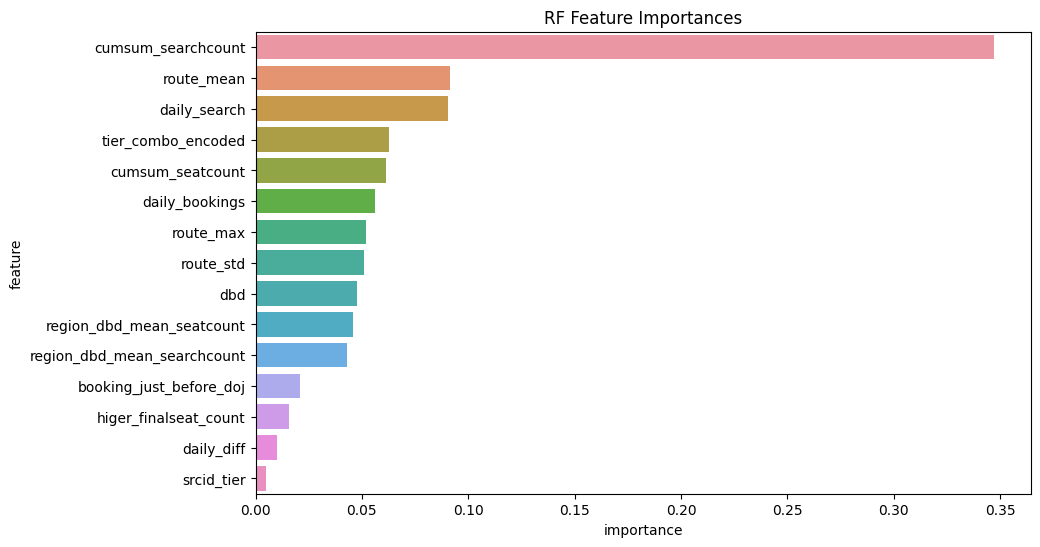

In [245]:
# Feature IMportance

imp = pd.DataFrame({'feature': X.columns, 
             'importance': rf.feature_importances_}).sort_values('importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=imp.head(20))
plt.title('RF Feature Importances')


#### Hyperparamter tuning

In [ ]:


param_dist = {
    'n_estimators': [180, 170,190],
    'max_depth': [15, 30, None],
    'min_samples_split': [12,8,10],
    'min_samples_leaf': [ 2, 4],
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,  
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train_scaled, y_train)

best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_val_scaled)
rmse = mean_squared_error(y_val, y_pred, squared=False)

print('Best Parameters:', random_search.best_params_)
print('Validation RMSE:', rmse)


#Best Parameters: {'n_estimators': 170, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 30}


#### Model 2: Catboost

In [246]:

cb = CatBoostRegressor(
    iterations=1500,
    depth=4,
    learning_rate=0.02,
    early_stopping_rounds=100,
    loss_function='RMSE',
    verbose=0
)

cb.fit(X_train_scaled,y_train)

y_pred_val = cb.predict(X_val_scaled)

y_pred_train = cb.predict(X_train_scaled)

print('RMSE of validation: ', mean_squared_error(y_val, y_pred_val,squared=False))
print('RMSE of training: ', mean_squared_error(y_train, y_pred_train,squared=False))

RMSE of validation:  681.4105238718024
RMSE of training:  679.6850196373805


#### Model 3: XGB

In [247]:


xgb = XGBRegressor()

xgb.fit(X_train_scaled,y_train)

y_pred_val = xgb.predict(X_val_scaled)

y_pred_train = xgb.predict(X_train_scaled)

print('RMSE of validation: ', mean_squared_error(y_val, y_pred_val,squared=False))
print('RMSE of training: ', mean_squared_error(y_train, y_pred_train,squared=False))

RMSE of validation:  587.5718747462549
RMSE of training:  576.9449669003072


#### Model 4: LGBM

In [248]:

lgbm = LGBMRegressor(
    boosting_type='goss',  # Better for smaller datasets
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    min_data_in_leaf=20
)


lgbm.fit(X_train_scaled,y_train)

y_pred_val = lgbm.predict(X_val_scaled)

y_pred_train = lgbm.predict(X_train_scaled)

print('RMSE of validation: ', mean_squared_error(y_val, y_pred_val,squared=False))
print('RMSE of training: ', mean_squared_error(y_train, y_pred_train,squared=False))

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2444
[LightGBM] [Info] Number of data points in the train set: 860160, numb

### Model 5: LSTM 

In [ ]:


# --- Step 1: Sort and reshape into sequences ---
# Sort your dataset by journey and dbd (time before journey)
train_sorted = train.sort_values(by=['doj', 'srcid', 'destid', 'dbd'])

# Select features (add your own)
features = ['srcid_tier', 'cumsum_seatcount', 'cumsum_searchcount', 'dbd',
       'higer_finalseat_count', 'route_mean', 'tier_combo',
       'tier_combo_encoded', 'region_dbd_mean_seatcount','booking_just_before_doj']  # Add more if needed
target = 'final_seat_count'

# Normalize features
scaler = StandardScaler()
train_sorted[features] = scaler.fit_transform(train_sorted[features])

# --- Step 2: Create sequences ---
# Example: group by journey id (e.g., doj + route) and create sequences
sequence_data = []
sequence_labels = []
for _, group in train_sorted.groupby(['doj', 'srcid', 'destid']):
    group = group.sort_values('dbd', ascending=False)  # D-30 to D-0
    
    # Optional: drop columns you don't want in training
    group = group.drop(columns=['doj'])

    X_seq = group[features].values
    y_val = group[target].values[-1]  # final seat count at D-0

    if len(X_seq) == 16:  # DBD between 15 and 30
        sequence_data.append(X_seq)
        sequence_labels.append(y_val)


X = np.array(sequence_data)  # shape: (samples, timesteps, features)
y = np.array(sequence_labels)

# --- Step 3: Train-Test Split ---
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)



from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

# Train
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))


from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_val).flatten()
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f"RMSE: {rmse:.2f}")


## Submission

In [252]:
t = pd.read_csv('/kaggle/input/redbus-challenge/test_8gqdJqH.csv')

test = df_trans[df_trans['doj']> date(2024,12,31)]
test = test[test.dbd>14]

In [253]:
t.doj.min(), t.doj.max()

('2025-01-01', '2025-02-28')

In [254]:
test['original_order'] = range(len(test))

# Sort for diff calculation: for each group, sort by decreasing dbd
test = test.sort_values(by=['doj', 'srcid', 'destid', 'dbd'], ascending=[True, True, True, False])

# Compute actual bookings by group
test['daily_bookings'] = test.groupby(['doj', 'srcid', 'destid'])['cumsum_seatcount'].diff().fillna(test['cumsum_seatcount'])
test['daily_search'] = test.groupby(['doj', 'srcid', 'destid'])['cumsum_searchcount'].diff().fillna(test['cumsum_searchcount'])
test['daily_diff'] = test.groupby(['doj', 'srcid', 'destid'])['daily_bookings'].diff().fillna(test['daily_bookings'])



test = test.sort_values(by='original_order')

# Drop helper columns if added
test = test.drop(columns=['original_order'])

test.head()

,doj,doi,srcid,destid,srcid_region,destid_region,srcid_tier,destid_tier,cumsum_seatcount,cumsum_searchcount,dbd,daily_bookings,daily_search,daily_diff
2083200,2025-01-01,2024-12-02,45,46,Karnataka,Tamil Nadu,Tier 1,Tier 1,6.0,626.0,30,6.0,626.0,6.0
2083201,2025-01-01,2024-12-02,46,45,Tamil Nadu,Karnataka,Tier 1,Tier 1,22.0,620.0,30,22.0,620.0,22.0
2083202,2025-01-01,2024-12-02,45,47,Karnataka,Andhra Pradesh,Tier 1,Tier 1,22.0,1136.0,30,22.0,1136.0,22.0
2083203,2025-01-01,2024-12-02,47,45,Andhra Pradesh,Karnataka,Tier 1,Tier 1,70.0,2140.0,30,70.0,2140.0,70.0
2083204,2025-01-01,2024-12-02,46,9,Tamil Nadu,Tamil Nadu,Tier 1,Tier2,9.0,768.0,30,9.0,768.0,9.0


In [255]:
test['day_of_week'] = test['doj'].apply(lambda x: x.strftime('%A'))  # e.g., 'Monday'

test['doj'] = pd.to_datetime(test['doj'])
test['year'] = test['doj'].apply(lambda x: x.year)

# Define Indian holidays for the relevant year(s)
indian_holidays = holidays.India(years=test['year'].unique())

# Get a set of dates 3 days before and after each holiday
holiday_buffer = set()

for holiday in indian_holidays.keys():
    for offset in range(-4, 5):  # -3 to +3 days
        holiday_buffer.add(holiday + timedelta(days=offset))

#train['near_holiday'] = train['doj'].isin(holiday_buffer)

is_highest_hol =[]
for i in test.index:
    doj=test.loc[i,'doj']
    dow=test.loc[i,'day_of_week']
    if doj in holiday_buffer:
        is_highest_hol.append(2)
    elif dow in ['Friday','Saturday','Sunday']:
        is_highest_hol.append(1)
    else:
        is_highest_hol.append(0.1)

        
test['higer_finalseat_count'] = is_highest_hol
test.head()   

,doj,doi,srcid,destid,srcid_region,destid_region,srcid_tier,destid_tier,cumsum_seatcount,cumsum_searchcount,dbd,daily_bookings,daily_search,daily_diff,day_of_week,year,higer_finalseat_count
2083200,2025-01-01,2024-12-02,45,46,Karnataka,Tamil Nadu,Tier 1,Tier 1,6.0,626.0,30,6.0,626.0,6.0,Wednesday,2025,0.1
2083201,2025-01-01,2024-12-02,46,45,Tamil Nadu,Karnataka,Tier 1,Tier 1,22.0,620.0,30,22.0,620.0,22.0,Wednesday,2025,0.1
2083202,2025-01-01,2024-12-02,45,47,Karnataka,Andhra Pradesh,Tier 1,Tier 1,22.0,1136.0,30,22.0,1136.0,22.0,Wednesday,2025,0.1
2083203,2025-01-01,2024-12-02,47,45,Andhra Pradesh,Karnataka,Tier 1,Tier 1,70.0,2140.0,30,70.0,2140.0,70.0,Wednesday,2025,0.1
2083204,2025-01-01,2024-12-02,46,9,Tamil Nadu,Tamil Nadu,Tier 1,Tier2,9.0,768.0,30,9.0,768.0,9.0,Wednesday,2025,0.1


In [256]:
test['route'] = test['srcid'].astype(str) + "_" + test['destid'].astype(str)

test['route_mean'] = test.apply(lambda x: mapper_mean.get((x['route'], x['dbd']), np.nan), axis=1)
test['route_max'] = test.apply(lambda x: mapper_max.get((x['route'], x['dbd']), np.nan), axis=1)
test['route_std'] = test.apply(lambda x: mapper_std.get((x['route'], x['dbd']), np.nan), axis=1)

test.head()

,doj,doi,srcid,destid,srcid_region,destid_region,srcid_tier,destid_tier,cumsum_seatcount,cumsum_searchcount,...,daily_bookings,daily_search,daily_diff,day_of_week,year,higer_finalseat_count,route,route_mean,route_max,route_std
2083200,2025-01-01,2024-12-02,45,46,Karnataka,Tamil Nadu,Tier 1,Tier 1,6.0,626.0,...,6.0,626.0,6.0,Wednesday,2025,0.1,45_46,6.678571,296.0,15.489748
2083201,2025-01-01,2024-12-02,46,45,Tamil Nadu,Karnataka,Tier 1,Tier 1,22.0,620.0,...,22.0,620.0,22.0,Wednesday,2025,0.1,46_45,5.538690,156.0,10.395817
2083202,2025-01-01,2024-12-02,45,47,Karnataka,Andhra Pradesh,Tier 1,Tier 1,22.0,1136.0,...,22.0,1136.0,22.0,Wednesday,2025,0.1,45_47,8.187500,258.0,17.110684
2083203,2025-01-01,2024-12-02,47,45,Andhra Pradesh,Karnataka,Tier 1,Tier 1,70.0,2140.0,...,70.0,2140.0,70.0,Wednesday,2025,0.1,47_45,5.672619,120.0,9.218007
2083204,2025-01-01,2024-12-02,46,9,Tamil Nadu,Tamil Nadu,Tier 1,Tier2,9.0,768.0,...,9.0,768.0,9.0,Wednesday,2025,0.1,46_9,11.714286,459.0,31.630908


In [257]:
test['srcid_tier']=test['srcid_tier'].map({'Tier 1':4,'Tier2':3,'Tier 3':2,'Tier 4':1})
test['destid_tier']=test['destid_tier'].map({'Tier 1':4,'Tier2':3,'Tier 3':2,'Tier 4':1})
test['tier_combo'] = test['srcid_tier'].astype(str) + "_" + test['destid_tier'].astype(str)
test['tier_combo_encoded'] = test['tier_combo'].map(tier_seat_map)

In [258]:
test['region_pair'] = test['srcid_region'] + '→' + test['destid_region']


# Merge this back to the original dataframe
test = test.merge(region_dbd_means, on=['region_pair', 'dbd'], how='left')


In [259]:
dojs_with_all_zeros = test.groupby(['doj','srcid','destid'])['cumsum_seatcount'].apply(lambda x: (x == 0).all())
dojs_with_all_zeros = dojs_with_all_zeros[dojs_with_all_zeros].index.tolist()
unique_pairs_count = test[['doj', 'srcid', 'destid']].drop_duplicates().shape[0]

print(len(dojs_with_all_zeros),unique_pairs_count)

test['key'] = list(zip(test['doj'], test['srcid'], test['destid']))

# Mark rows: 1 if in list, else 0
test['booking_just_before_doj'] = test['key'].isin(dojs_with_all_zeros).astype(int)

# Optionally drop helper columns
test.drop(columns=['key'], inplace=True)

test.head()

995 5900


,doj,doi,srcid,destid,srcid_region,destid_region,srcid_tier,destid_tier,cumsum_seatcount,cumsum_searchcount,...,route,route_mean,route_max,route_std,tier_combo,tier_combo_encoded,region_pair,region_dbd_mean_seatcount,region_dbd_mean_searchcount,booking_just_before_doj
0,2025-01-01,2024-12-02,45,46,Karnataka,Tamil Nadu,4,4,6.0,626.0,...,45_46,6.678571,296.0,15.489748,4_4,12.4,Karnataka→Tamil Nadu,10.207143,368.726786,0
1,2025-01-01,2024-12-02,46,45,Tamil Nadu,Karnataka,4,4,22.0,620.0,...,46_45,5.538690,156.0,10.395817,4_4,12.4,Tamil Nadu→Karnataka,9.929762,232.344048,0
2,2025-01-01,2024-12-02,45,47,Karnataka,Andhra Pradesh,4,4,22.0,1136.0,...,45_47,8.187500,258.0,17.110684,4_4,12.4,Karnataka→Andhra Pradesh,5.477307,427.693080,0
3,2025-01-01,2024-12-02,47,45,Andhra Pradesh,Karnataka,4,4,70.0,2140.0,...,47_45,5.672619,120.0,9.218007,4_4,12.4,Andhra Pradesh→Karnataka,4.065476,216.485119,0
4,2025-01-01,2024-12-02,46,9,Tamil Nadu,Tamil Nadu,4,3,9.0,768.0,...,46_9,11.714286,459.0,31.630908,4_3,10.8,Tamil Nadu→Tamil Nadu,8.722636,565.479828,0


In [260]:
#test['search_to_seat_ratio'] = test['cumsum_searchcount'] / (test['cumsum_seatcount'] + 1)


In [261]:

test.drop(['year','day_of_week','doi','srcid_region','destid_region','route','destid_tier','route','region_pair','tier_combo'],axis=1,inplace=True)

In [262]:
test['doj'] = pd.to_datetime(test['doj'])
test['doj'] = test['doj'].dt.strftime('%Y-%m-%d') 

In [263]:
test_sorted = test.set_index(['doj', 'srcid', 'destid']).loc[
    t.set_index(['doj', 'srcid', 'destid']).index
].reset_index()

test_sorted.shape

(94400, 18)

In [264]:
test_sorted.tail()

,doj,srcid,destid,srcid_tier,cumsum_seatcount,cumsum_searchcount,dbd,daily_bookings,daily_search,daily_diff,higer_finalseat_count,route_mean,route_max,route_std,tier_combo_encoded,region_dbd_mean_seatcount,region_dbd_mean_searchcount,booking_just_before_doj
94395,2025-01-27,32,19,4,4.0,236.0,19,0.0,0.0,-4.0,0.1,3.964286,92.0,8.132944,12.4,0.860119,35.190476,0
94396,2025-01-27,32,19,4,4.0,236.0,18,0.0,0.0,0.0,0.1,4.577381,92.0,8.766551,12.4,1.122024,37.651786,0
94397,2025-01-27,32,19,4,16.0,236.0,17,12.0,0.0,12.0,0.1,5.452381,140.0,10.773268,12.4,1.160714,40.264881,0
94398,2025-01-27,32,19,4,16.0,296.0,16,0.0,60.0,-12.0,0.1,6.440476,140.0,11.472615,12.4,1.511905,46.401786,0
94399,2025-01-27,32,19,4,16.0,320.0,15,0.0,24.0,0.0,0.1,7.529762,140.0,12.387882,12.4,1.619048,53.160714,0


In [265]:
test_sorted.drop(['doj','srcid','destid'],axis=1,inplace=True)
test_sorted.head()

,srcid_tier,cumsum_seatcount,cumsum_searchcount,dbd,daily_bookings,daily_search,daily_diff,higer_finalseat_count,route_mean,route_max,route_std,tier_combo_encoded,region_dbd_mean_seatcount,region_dbd_mean_searchcount,booking_just_before_doj
0,4,4.0,146.0,30,4.0,146.0,4.0,0.1,5.538690,156.0,10.395817,12.4,9.929762,232.344048,0
1,4,4.0,182.0,29,0.0,36.0,-4.0,0.1,7.130952,196.0,13.261357,12.4,2.143750,39.238690,0
2,4,4.0,200.0,28,0.0,18.0,0.0,0.1,8.895833,244.0,16.229387,12.4,2.344940,43.008036,0
3,4,6.0,222.0,27,2.0,22.0,2.0,0.1,10.797619,290.0,19.171377,12.4,2.215179,47.650595,0
4,4,6.0,234.0,26,0.0,12.0,-2.0,0.1,12.907738,348.0,22.402705,12.4,2.605060,51.577381,0


In [266]:
X_test = scaler.transform(test_sorted)

In [267]:
test_sorted.isna().sum()

srcid_tier                     0
cumsum_seatcount               0
cumsum_searchcount             0
dbd                            0
daily_bookings                 0
daily_search                   0
daily_diff                     0
higer_finalseat_count          0
route_mean                     0
route_max                      0
route_std                      0
tier_combo_encoded             0
region_dbd_mean_seatcount      0
region_dbd_mean_searchcount    0
booking_just_before_doj        0
dtype: int64

In [268]:
test_sorted['final_seatcount'] = rf.predict(X_test)
test_sorted = test_sorted[test_sorted.dbd==test_sorted.dbd.min()]



submit=pd.DataFrame()
submit['route_key'] = t['route_key']
submit['final_seatcount'] = test_sorted.loc[test_sorted.dbd==test_sorted.dbd.min(),'final_seatcount'].values

submit.head()

,route_key,final_seatcount
0,2025-02-11_46_45,3562.654211
1,2025-01-20_17_23,1986.873671
2,2025-01-08_02_14,1231.300722
3,2025-01-08_08_47,1435.638322
4,2025-01-08_09_46,4013.602148


In [269]:
submit.to_csv('submission.csv',index=False)
